# EP4 - Comparação: AE, DAE e VAE

Resumo das explorações realizadas:
- Foi treinado três arquiteturas: AE, DAE e VAE, utilizando o dataset FashionMNIST.
- Foi comparada as perdas e visualizamos algumas reconstruções.
- Além disso, foi explorado um aspecto adicional: **o impacto da dimensão do espaço latente**.

- Também foi feito uma análise com t-SNE:
  * Foi visualizado o dataset original (amostras brutas em 784 dimensões) reduzido para 2D com t-SNE.
  * Foi visualizado as mesmas amostras no espaço latente do AE (de dimensão 10) e as reduziremos para 2D com t-SNE.
  * Foi comparado as duas visualizações para entender se a compressão retém alguma estrutura nos dados.

## Imports

In [1]:
################################
# IMPORTS
################################
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import numpy as np
import math
import pandas as pd

In [2]:
# Verifica se CUDA está disponível
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Device: cuda


## Dataset

Aqui será carregado o dataset. Foi utilizado o FashionMNIST e será dividido em treino teste e validação.

Ao carregar as imagens, é realizado uma normalização das imagens para que elas estejam em uma matriz com valores entre -1 e 1.

Dados carregados:
Train: 54000 samples
Val:   6000 samples
Test:  10000 samples


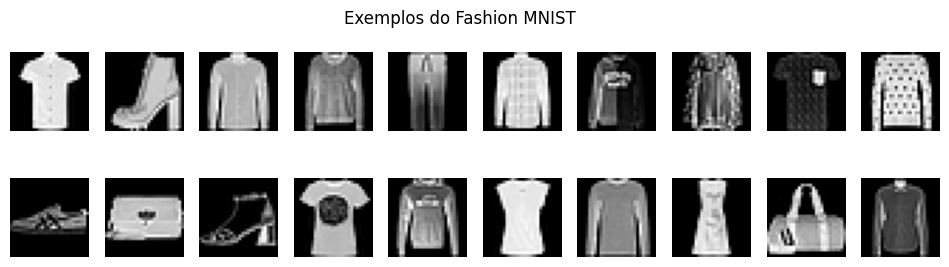

In [3]:
def carrega_dataset(validation_set_percent=0.1, batch_size=128, verbose=False):
    transform_list = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)),
        ]
    )

    training_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform_list)
    test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform_list)

    # Split train/val
    n_val = int(len(training_data)*validation_set_percent)
    n_train = len(training_data) - n_val
    train_set, val_set = random_split(training_data, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, pin_memory=True)

    if verbose:
        print("Dados carregados:")
        print(f"Train: {len(train_set)} samples")
        print(f"Val:   {len(val_set)} samples")
        print(f"Test:  {len(test_data)} samples")

        figure = plt.figure(figsize=(12, 3))
        plt.suptitle("Exemplos do Fashion MNIST")
        rows, cols = 2, 10
        for i in range(1, rows*cols+1):
            sample_idx = torch.randint(len(training_data), size=(1,)).item()
            img, label = training_data[sample_idx]
            figure.add_subplot(rows, cols, i)
            plt.axis("off")
            plt.imshow(img.squeeze(), cmap="gray")
        plt.show()

    return train_dataloader, val_dataloader, test_dataloader

train_dataloader, val_dataloader, test_dataloader = carrega_dataset(validation_set_percent=0.1, batch_size=256, verbose=True)

## Setup do modelo

In [4]:
################################
# Definições das funções de perda
################################

def ae_loss(recons, input):
    return F.mse_loss(recons, input)

def vae_loss(recons, input, mu, log_var, kld_weight):
    recons_loss = F.mse_loss(recons, input)
    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0)
    return recons_loss + kld_weight * kld_loss

In [5]:
################################
# Criação das classes das arquiteturas
################################

# ### 1. Autoencoder Simples (AE)
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_size=784, latent_dim=10):
        super(SimpleAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_size),
            nn.Tanh()
        )
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed
    
    def get_latent(self, x):
        # Retorna a representação latente
        return self.encoder(x)

# ### 2. Denoising Autoencoder (DAE)
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_size=784, latent_dim=10):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_size),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed

    def add_noise(self, x, noise_factor=0.3):
        x_noisy = x + noise_factor * torch.randn_like(x)
        x_noisy = torch.clip(x_noisy, -1.0, 1.0)
        return x_noisy
    
    def get_latent(self, x):
        return self.encoder(x)

# ### 3. Variational Autoencoder (VAE)
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size=784, latent_dim=10):
        super(VariationalAutoencoder, self).__init__()

        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size,512)
        )
        self.fc21 = nn.Linear(512, latent_dim) # mu
        self.fc22 = nn.Linear(512, latent_dim) # log_var
        self.relu = nn.ReLU()
        
        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, input_size)
        self.latent_dim = latent_dim

    def encode(self, x):
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def decode(self, z):
        z = self.relu(self.fc3(z))
        return torch.tanh(self.fc4(z))

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        prediction = self.decode(z)
        return prediction, mu, logvar
    
    def sample(self, num_samples:int):
        z = torch.randn(num_samples, self.latent_dim).to(device)
        samples = self.decode(z)
        return samples

    def get_latent(self, x):
        # Para o VAE, o latente é mu
        mu, logvar = self.encode(x)
        return mu

In [6]:
################################
# Funções de Treinamento e avaliação
################################
@torch.inference_mode()
def eval_loop_ae(dataloader, model, loss_fn, denoising=False):
    model.eval()
    eval_loss = 0
    num_batches = len(dataloader)

    for X, _ in dataloader:
        X = X.to(device)
        if denoising and hasattr(model, 'add_noise'):
            recons = model(X) # Aval após treino do DAE sem ruído
        else:
            recons = model(X)
        X = X.view(-1, 784)
        loss = loss_fn(recons, X)
        eval_loss += loss.item()

    eval_loss /= num_batches
    return eval_loss

def train_loop_ae(dataloader, model, loss_fn, optimizer, denoising=False, noise_factor=0.3):
    model.train()
    train_loss = 0
    num_batches = len(dataloader)

    for X, _ in dataloader:
        X = X.to(device)

        if denoising and hasattr(model, 'add_noise'):
            X_noisy = model.add_noise(X, noise_factor=noise_factor)
            recons = model(X_noisy)
        else:
            recons = model(X)

        X = X.view(-1, 784)
        loss = loss_fn(recons, X)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    train_loss /= num_batches
    return train_loss

@torch.inference_mode()
def eval_loop_vae(dataloader, model, loss_fn):
    model.eval()
    eval_loss = 0
    num_batches = len(dataloader)

    for X, _ in dataloader:
        X = X.to(device)
        recons, mu, logvar = model(X)
        X = X.view(-1, 784)
        kld_weight = X.shape[0]/60000
        loss = loss_fn(recons, X, mu, logvar, kld_weight)
        eval_loss += loss.item()

    eval_loss /= num_batches
    return eval_loss

def train_loop_vae(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0
    num_batches = len(dataloader)

    for X, _ in dataloader:
        X = X.to(device)
        recons, mu, logvar = model(X)
        X = X.view(-1, 784)
        kld_weight = X.shape[0]/60000
        loss = loss_fn(recons, X, mu, logvar, kld_weight)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    train_loss /= num_batches
    return train_loss

## Treinamento

In [7]:
################################
# Definições variáveis do treinamento
################################
epochs = 10
lr = 3e-3

In [8]:
# ## Treinando as Redes (Arquiteturas Iniciais)

# Treinar AE
epochs = 10
lr = 3e-3
ae = SimpleAutoencoder(latent_dim=10).to(device)
optimizer_ae = torch.optim.AdamW(ae.parameters(), lr=lr)
print("Treinando AE (latente=10)...")
for t in range(epochs):
    train_loss = train_loop_ae(train_dataloader, ae, ae_loss, optimizer_ae, denoising=False)
    val_loss = eval_loop_ae(val_dataloader, ae, ae_loss, denoising=False)
    print(f"Epoch {t+1}/{epochs} AE: train_loss={train_loss:.3f}, val_loss={val_loss:.3f}")

print("Treinamento do AE (10) concluído!\n")

# DAE
dae = DenoisingAutoencoder(latent_dim=10).to(device)
optimizer_dae = torch.optim.AdamW(dae.parameters(), lr=lr)
print("Treinando DAE...")
for t in range(epochs):
    train_loss = train_loop_ae(train_dataloader, dae, ae_loss, optimizer_dae, denoising=True, noise_factor=0.3)
    val_loss = eval_loop_ae(val_dataloader, dae, ae_loss, denoising=False)
    print(f"Epoch {t+1}/{epochs} DAE: train_loss={train_loss:.3f}, val_loss={val_loss:.3f}")

print("Treinamento do DAE concluído!\n")

# VAE
vae = VariationalAutoencoder(latent_dim=10).to(device)
optimizer_vae = torch.optim.AdamW(vae.parameters(), lr=3.5e-3)
print("Treinando VAE...")
for t in range(epochs):
    train_loss = train_loop_vae(train_dataloader, vae, vae_loss, optimizer_vae)
    val_loss = eval_loop_vae(val_dataloader, vae, vae_loss)
    print(f"Epoch {t+1}/{epochs} VAE: train_loss={train_loss:.3f}, val_loss={val_loss:.3f}")

print("Treinamento do VAE concluído!\n")

Treinando AE (latente=10)...
Epoch 1/10 AE: train_loss=0.096, val_loss=0.067
Epoch 2/10 AE: train_loss=0.063, val_loss=0.061
Epoch 3/10 AE: train_loss=0.058, val_loss=0.058
Epoch 4/10 AE: train_loss=0.056, val_loss=0.056
Epoch 5/10 AE: train_loss=0.054, val_loss=0.055
Epoch 6/10 AE: train_loss=0.053, val_loss=0.054
Epoch 7/10 AE: train_loss=0.052, val_loss=0.053
Epoch 8/10 AE: train_loss=0.052, val_loss=0.053
Epoch 9/10 AE: train_loss=0.051, val_loss=0.052
Epoch 10/10 AE: train_loss=0.051, val_loss=0.052
Treinamento do AE (10) concluído!

Treinando DAE...
Epoch 1/10 DAE: train_loss=0.096, val_loss=0.067
Epoch 2/10 DAE: train_loss=0.064, val_loss=0.061
Epoch 3/10 DAE: train_loss=0.060, val_loss=0.058
Epoch 4/10 DAE: train_loss=0.058, val_loss=0.057
Epoch 5/10 DAE: train_loss=0.056, val_loss=0.056
Epoch 6/10 DAE: train_loss=0.055, val_loss=0.056
Epoch 7/10 DAE: train_loss=0.054, val_loss=0.055
Epoch 8/10 DAE: train_loss=0.054, val_loss=0.054
Epoch 9/10 DAE: train_loss=0.053, val_loss=0.0

## Visualização das reconstruções

Abaixo será plotado as visualizações das reconstruções dos modelos construidos acima

Reconstruções do AE:


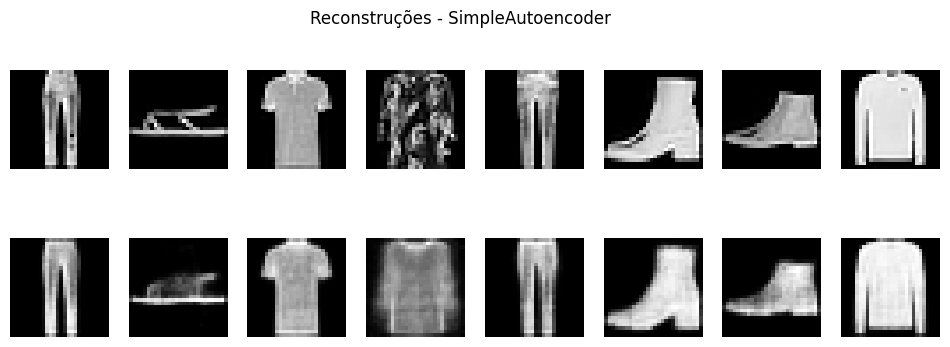

Reconstruções do DAE (entrada limpa):


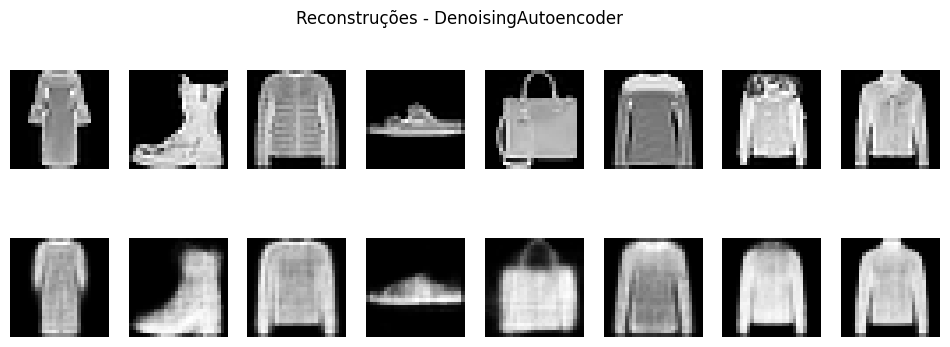

Reconstruções do DAE (entrada ruidosa):


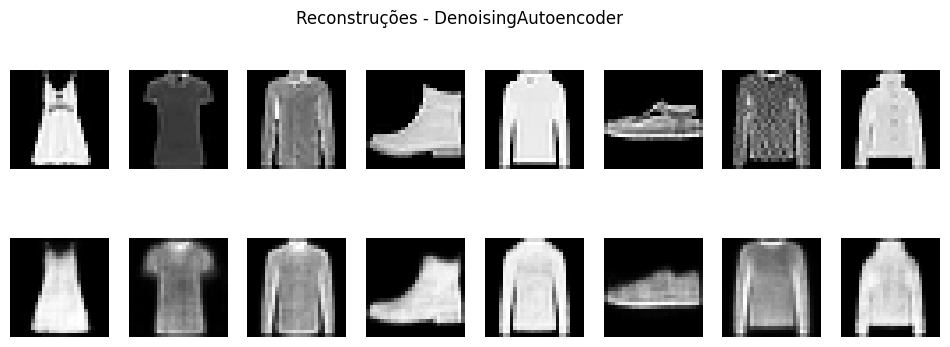

Reconstruções do VAE:


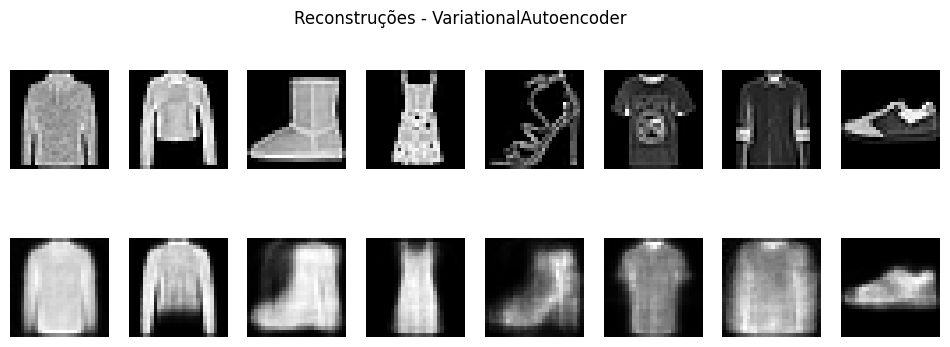

In [9]:
@torch.inference_mode()
def plot_reconstructions(model, dataloader, num_images=8, denoising=False, noise_factor=0.3, vae=False):
    model.eval()
    for X, _ in dataloader:
        X = X.to(device)
        if denoising and hasattr(model, 'add_noise'):
            X_noisy = model.add_noise(X, noise_factor)
            recons = model(X_noisy) if not vae else model(X_noisy)[0]
        else:
            recons = model(X) if not vae else model(X)[0]
        break

    X = X[:num_images].detach().cpu()
    recons = recons[:num_images].detach().cpu().view(num_images, 1, 28, 28)

    figure = plt.figure(figsize=(12, 4))
    plt.suptitle(f"Reconstruções - {model.__class__.__name__}")
    for i in range(num_images):
        # Original
        ax = figure.add_subplot(2, num_images, i+1)
        ax.imshow(X[i].squeeze(), cmap='gray')
        ax.axis('off')

        # Reconstrução
        ax = figure.add_subplot(2, num_images, num_images + i + 1)
        ax.imshow(recons[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

print("Reconstruções do AE:")
plot_reconstructions(ae, test_dataloader, num_images=8, denoising=False)

print("Reconstruções do DAE (entrada limpa):")
plot_reconstructions(dae, test_dataloader, num_images=8, denoising=False)

print("Reconstruções do DAE (entrada ruidosa):")
plot_reconstructions(dae, test_dataloader, num_images=8, denoising=True, noise_factor=0.3)

print("Reconstruções do VAE:")
plot_reconstructions(vae, test_dataloader, num_images=8, denoising=False, vae=True)

## Impacto da Dimensão Latente

Será treinado um outro AE com uma dimensão latente diferente (por exemplo, 32) e comparar as perdas.  
É esperado que aumentar a dimensão latente pode melhorar a reconstrução (menor perda), mas diminui a capacidade de compressão.

In [10]:
ae_latent32 = SimpleAutoencoder(latent_dim=32).to(device)
optimizer_ae32 = torch.optim.AdamW(ae_latent32.parameters(), lr=lr)
print("Treinando AE (latente=32)...")
for t in range(epochs):
    train_loss = train_loop_ae(train_dataloader, ae_latent32, ae_loss, optimizer_ae32, denoising=False)
    val_loss = eval_loop_ae(val_dataloader, ae_latent32, ae_loss, denoising=False)
    print(f"Epoch {t+1}/{epochs} AE(32): train_loss={train_loss:.3f}, val_loss={val_loss:.3f}")

print("Treinamento do AE(32) concluído!\n")

# Vamos comparar a perda final no conjunto de teste
test_loss_ae10 = eval_loop_ae(test_dataloader, ae, ae_loss, denoising=False)
test_loss_ae32 = eval_loop_ae(test_dataloader, ae_latent32, ae_loss, denoising=False)
print(f"Test Loss AE(10): {test_loss_ae10:.4f}")
print(f"Test Loss AE(32): {test_loss_ae32:.4f}")

Treinando AE (latente=32)...
Epoch 1/10 AE(32): train_loss=0.088, val_loss=0.054
Epoch 2/10 AE(32): train_loss=0.048, val_loss=0.044
Epoch 3/10 AE(32): train_loss=0.042, val_loss=0.041
Epoch 4/10 AE(32): train_loss=0.039, val_loss=0.039
Epoch 5/10 AE(32): train_loss=0.037, val_loss=0.038
Epoch 6/10 AE(32): train_loss=0.036, val_loss=0.037
Epoch 7/10 AE(32): train_loss=0.035, val_loss=0.036
Epoch 8/10 AE(32): train_loss=0.035, val_loss=0.036
Epoch 9/10 AE(32): train_loss=0.034, val_loss=0.036
Epoch 10/10 AE(32): train_loss=0.033, val_loss=0.035
Treinamento do AE(32) concluído!

Test Loss AE(10): 0.0519
Test Loss AE(32): 0.0347


É observado que, se aumentar a dimensão latente reduziu a perda de reconstrução.

## Visualização com t-SNE

Aqui será comparado a estrutura dos dados no espaço original vs. o espaço latente do AE(10).

Passos:
1. Pegamos um subconjunto de dados (por exemplo 1000 amostras) do conjunto de teste.
2. Obtemos as features originais (flatten 784) e as latentes (10 dimensões).
3. Aplicamos t-SNE para reduzir para 2D nos dois casos.
4. Plotamos com cores baseadas na classe.

É esperado ver se a estrutura latente mantém algum agrupamento semelhante ao espaço original.

In [11]:
@torch.inference_mode()
def get_subset_features(model, dataloader, max_samples=1000):
    X_all = []
    y_all = []
    for X, y in dataloader:
        X_all.append(X)
        y_all.append(y)
        if len(torch.cat(X_all)) >= max_samples:
            break
    X_all = torch.cat(X_all)[:max_samples]
    y_all = torch.cat(y_all)[:max_samples]

    X_all = X_all.to(device)
    latent = model.get_latent(X_all)
    # Retornar também o X flatten
    X_flat = X_all.view(X_all.size(0), -1).cpu().numpy()
    latent = latent.detach().cpu().numpy()
    y_all = y_all.numpy()
    return X_flat, latent, y_all

X_flat, Z_ae, labels = get_subset_features(ae, test_dataloader, max_samples=1000)

print("Aplicando t-SNE no espaço original (784d -> 2d)...")
tsne_original = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne_original.fit_transform(X_flat)

print("Aplicando t-SNE no espaço latente do AE (10d -> 2d)...")
tsne_latent = TSNE(n_components=2, random_state=42, perplexity=30)
Z_2d = tsne_latent.fit_transform(Z_ae)


Aplicando t-SNE no espaço original (784d -> 2d)...
Aplicando t-SNE no espaço latente do AE (10d -> 2d)...


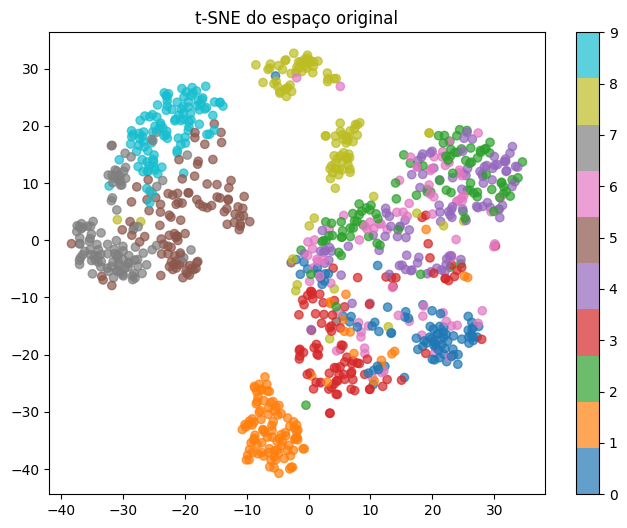

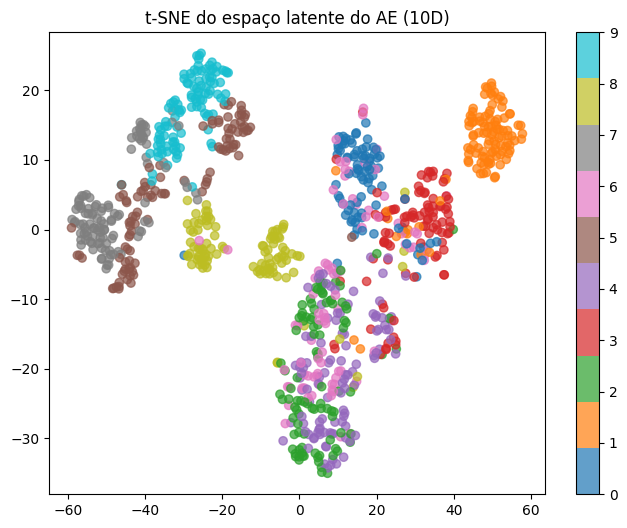

In [12]:
################################
# Plotando os resultados do t-SNE
################################

def plot_tsne_results(X_2d, labels, title):
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

plot_tsne_results(X_2d, labels, "t-SNE do espaço original")
plot_tsne_results(Z_2d, labels, "t-SNE do espaço latente do AE (10D)")

## Avaliação

Para realizar a avaliação no conjunto de teste de forma quantitativa, foi utilizado a métrica PSNR. Abaixo há uma breve explicação da métrica:

**Explicação Matemática do PSNR**

O *Peak Signal-to-Noise Ratio* (PSNR) é uma métrica comumente utilizada para avaliar a qualidade de imagens reconstruídas ou comprimidas em relação à imagem original. Ele é definido a partir do erro quadrático médio (*Mean Squared Error*, MSE) entre a imagem original \(I\) e a imagem reconstruída \(\hat{I}\).

1. **Cálculo do MSE**

   Seja \(I\) a imagem original e \(\hat{I}\) a imagem reconstruída, ambas com dimensão \(M \times N\). O MSE é dado por:

   $$
   \text{MSE} = \frac{1}{M \times N} \sum_{x=1}^{M}\sum_{y=1}^{N}(I(x,y) - \hat{I}(x,y))^2
   $$

2. **Definição do PSNR**

   O PSNR baseia-se na razão entre o valor máximo do sinal (intensidade máxima do pixel, \(\text{MAX}_I\)) e o MSE. Se as imagens estão normalizadas no intervalo \([0,1]\), então \(\text{MAX}_I = 1\). Em geral, se os pixels estão no intervalo \([0, 255]\), então \(\text{MAX}_I = 255\).

   O PSNR (em decibéis, dB) é definido como:

   $$
   \text{PSNR} = 10 \cdot \log_{10}\left(\frac{\text{MAX}_I^2}{\text{MSE}}\right)
   $$

**Interpretação:**

- Valores mais elevados de PSNR indicam que a imagem reconstruída está mais próxima da imagem original, i.e., melhor qualidade de reconstrução.
- Valores mais baixos de PSNR indicam maior diferença entre a imagem reconstruída e a original, representando pior qualidade.

In [13]:
@torch.inference_mode()
def compute_psnr(dataloader, model, vae=False, denoising=False, noise_factor=0.3):
    model.eval()
    psnr_values = []

    for X, _ in dataloader:
        X = X.to(device)
        if denoising and hasattr(model, 'add_noise'):
            X_input = model.add_noise(X, noise_factor=noise_factor)
        else:
            X_input = X
        
        if vae:
            recons, _, _ = model(X_input)
        else:
            recons = model(X_input)
        
        # Redimensionar
        X = X.view(-1, 1, 28, 28)
        recons = recons.view(-1, 1, 28, 28)
        
        # Converte de [-1,1] para [0,1]
        X_01 = (X + 1) / 2
        recons_01 = (recons + 1) / 2
        
        # Calcula MSE por imagem
        mse = ((X_01 - recons_01) ** 2).mean(dim=[1,2,3])  # média por imagem
        # Calcula PSNR por imagem
        # PSNR = 10 * log10(1 / mse) pois o pixel max em [0,1] é 1.
        psnr = 10 * torch.log10(1 / mse)
        psnr_values.append(psnr.cpu())

    psnr_values = torch.cat(psnr_values)
    return psnr_values.mean().item()

psnr_ae10 = compute_psnr(test_dataloader, ae, vae=False, denoising=False)
psnr_dae = compute_psnr(test_dataloader, dae, vae=False, denoising=False) # PSNR com input sem ruído
psnr_vae = compute_psnr(test_dataloader, vae, vae=True, denoising=False)
psnr_ae32 = compute_psnr(test_dataloader, ae_latent32, vae=False, denoising=False)

results = {
    "Modelo": ["AE (lat_dim=10)", "DAE (lat_dim=10)", "VAE (lat_dim=10)", "AE (lat_dim=32)"],
    "PSNR Médio (dB)": [psnr_ae10, psnr_dae, psnr_vae, psnr_ae32]
}

df_results = pd.DataFrame(results)
display(df_results)


,Modelo,PSNR Médio (dB)
0,AE (lat_dim=10),19.800247
1,DAE (lat_dim=10),19.552540
2,VAE (lat_dim=10),17.404177
3,AE (lat_dim=32),21.680725


## Conclusão

Foi possivel observar se o t-SNE no espaço latente mostra algum agrupamento por classe semelhante ao original.  
Ao comparar a perda de reconstrução do AE com dimensão latente 10 vs 32, nota-se que há melhora na reconstrução ao aumentar a dimensionalidade do espaço latente.

Esse tipo de exploração nos ajuda a entender:
- A qualidade da representação latente aprendida pelo AE (através do t-SNE).
- O trade-off entre capacidade de compressão (dimensão latente menor) e qualidade da reconstrução.


Além disso, ao olhar o resultados de PSNR de AE, DAE e VAE no conjunto de teste, vemos que o melhor é o AE.